In [1]:
!pip3 install torch torchvision

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision import datasets, transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from torch.nn.modules.activation import Tanhshrink
transform = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
training_dataset = datasets.MNIST(root='./data', train=True, download=True,transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True,transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)


In [5]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  # print(image.shape)
  image = image * np.array((0.5,)) + np.array((0.5,))
  image = image.clip(0,1)
  return image

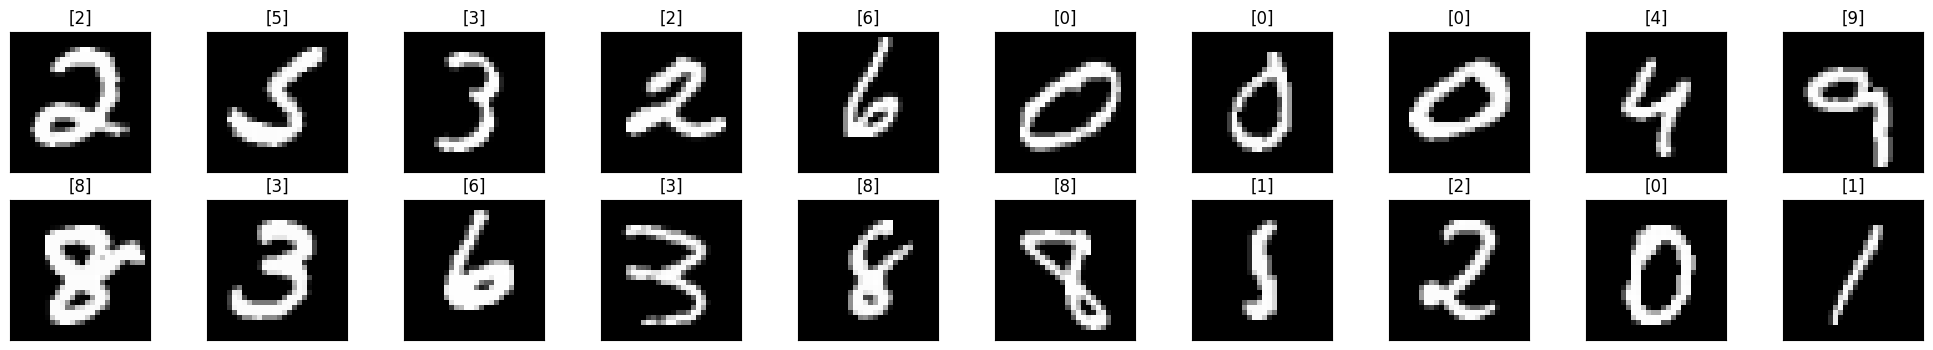

In [6]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[],yticks=[])
  plt.imshow(im_convert(images[idx]), cmap='gray')
  ax.set_title([labels[idx].item()])


In [7]:
x = torch.Tensor([[1,2,3],[4,5,6]])
# torch.flatten(x)
x = x.view(-1,6)
print(x)

tensor([[1., 2., 3., 4., 5., 6.]])


In [20]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,20,5,1)
    self.conv2 = nn.Conv2d(20,50,5,1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500,10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    # torch.flatten(x)
    x = x.view(-1,4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)  # note that relu is not used at last fc layer bcz we want logits for cross entropy loss(softmax in BCE)
    return x

In [21]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [22]:
for p in model.parameters():
  if p.requires_grad:
    print(p.numel())
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

500
20
25000
50
400000
500
5000
10
431080


In [23]:
# @title Cross Entropy Loss Example
# import torch
# import torch.nn as nn

# # Define some sample input data and labels.
# input_data = torch.Tensor([[0, 0.5, 1],[1,0.5,0]])  # 2 samples, 3 classes.
# weight = torch.Tensor([0,1,2])
# print(input_data)
# labels = torch.LongTensor([2, 1 ])  # target class indices.
# print(labels)
# # Create a criterion that measures the cross entropy loss.
# criterion = nn.CrossEntropyLoss(weight=weight)

# # Compute the loss.
# loss = criterion(input_data, labels)

# # Print the loss.
# print(loss)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [25]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for i in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _,preds = torch.max(outputs, 1)  # this gives indices of max elements
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels)

  epoch_loss = running_loss/len(training_loader)
  epoch_acc = running_corrects.float()/len(training_loader)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  print(f"epoch {i+1}:")
  print('training loss:{:.4f}, training accuracy:{:.4f}'.format(epoch_loss, epoch_acc.item()))
  # Testing with Validation Dataset
  with torch.no_grad():
    for val_inputs, val_labels in validation_loader:
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model.forward(val_inputs)
      val_loss = criterion(val_outputs, val_labels)

      _,val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels)
  val_epoch_loss = val_running_loss/len(validation_loader)
  val_epoch_acc = val_running_corrects.float()/len(validation_loader)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  print('Validation loss:{:.4f}, Validation Accuracy:{:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
  print("\n")




epoch 1:
training loss:0.5993, training accuracy:83.8300
Validation loss:0.1876, Validation Accuracy:94.2600


epoch 2:
training loss:0.1527, training accuracy:95.5000
Validation loss:0.1034, Validation Accuracy:96.7900


epoch 3:
training loss:0.1011, training accuracy:97.0200
Validation loss:0.0780, Validation Accuracy:97.7000


epoch 4:
training loss:0.0781, training accuracy:97.7000
Validation loss:0.0653, Validation Accuracy:98.0500


epoch 5:
training loss:0.0645, training accuracy:98.0317
Validation loss:0.0533, Validation Accuracy:98.3600


epoch 6:
training loss:0.0541, training accuracy:98.3500
Validation loss:0.0472, Validation Accuracy:98.4600


epoch 7:
training loss:0.0481, training accuracy:98.5050
Validation loss:0.0411, Validation Accuracy:98.6600


epoch 8:
training loss:0.0431, training accuracy:98.7300
Validation loss:0.0381, Validation Accuracy:98.7600


epoch 9:
training loss:0.0388, training accuracy:98.8200
Validation loss:0.0366, Validation Accuracy:98.7300


e

Text(0.5, 1.0, 'Loss')

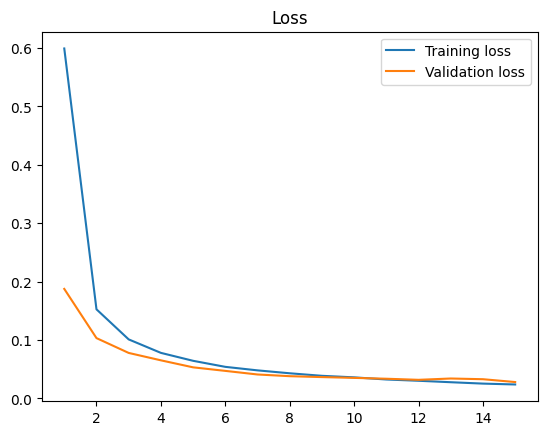

In [26]:
plt.plot(range(1,epochs+1),running_loss_history,label='Training loss')
plt.plot(range(1,epochs+1),val_running_loss_history, label="Validation loss")
plt.legend()
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

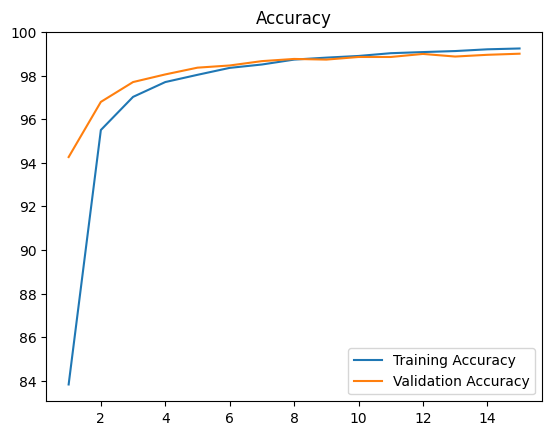

In [27]:
running_corrects_history = np.array([t.cpu().numpy() for t in running_corrects_history])
val_running_corrects_history = np.array([t.cpu().numpy() for t in val_running_corrects_history])
plt.plot(range(1,epochs+1),running_corrects_history,label='Training Accuracy')
plt.plot(range(1,epochs+1),val_running_corrects_history,label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")


Text(0.5, 1.0, 'Error')

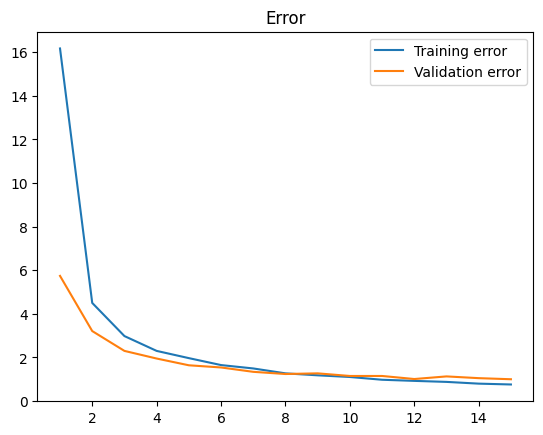

In [28]:
plt.plot(range(1,epochs+1),100-np.array(running_corrects_history),label='Training error')
plt.plot(range(1,epochs+1),100-np.array(val_running_corrects_history),label='Validation error')
plt.legend()
plt.title("Error")

**Testing with new image from internet**

--2023-10-27 14:04:30--  https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg
Resolving images.homedepot-static.com (images.homedepot-static.com)... 35.186.226.36
Connecting to images.homedepot-static.com (images.homedepot-static.com)|35.186.226.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21010 (21K) [image/jpeg]
Saving to: ‘downloaded_image.jpg’

downloaded_image.jp 100%[===================>]  20.52K  --.-KB/s    in 0.01s   

2023-10-27 14:04:30 (2.07 MB/s) - ‘downloaded_image.jpg’ saved [21010/21010]



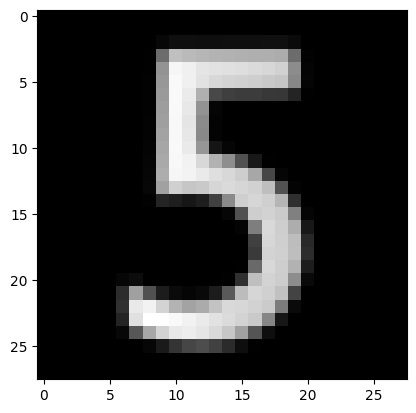

In [29]:
!wget 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg' -O downloaded_image.jpg
import cv2 as cv
from PIL import Image
img = cv.imread('downloaded_image.jpg')
grey_img = cv.cvtColor(img,cv.COLOR_BGR2GRAY) # converting to gray scale
img = cv.bitwise_not(grey_img) # invert the img,change white background to black
# print(type(img))
img1 = Image.fromarray(img)
img1 = transform(img1)
# print(type(img1))
# print(img1.shape)
plt.imshow(im_convert(img1),cmap='gray')


In [30]:
# img1 = img1.view(img1.shape[0],-1)
# print(img1.shape)
pred = model.forward(img1.to(device))
_,pred_label = torch.max(pred, 1)
print(pred_label.item())


5


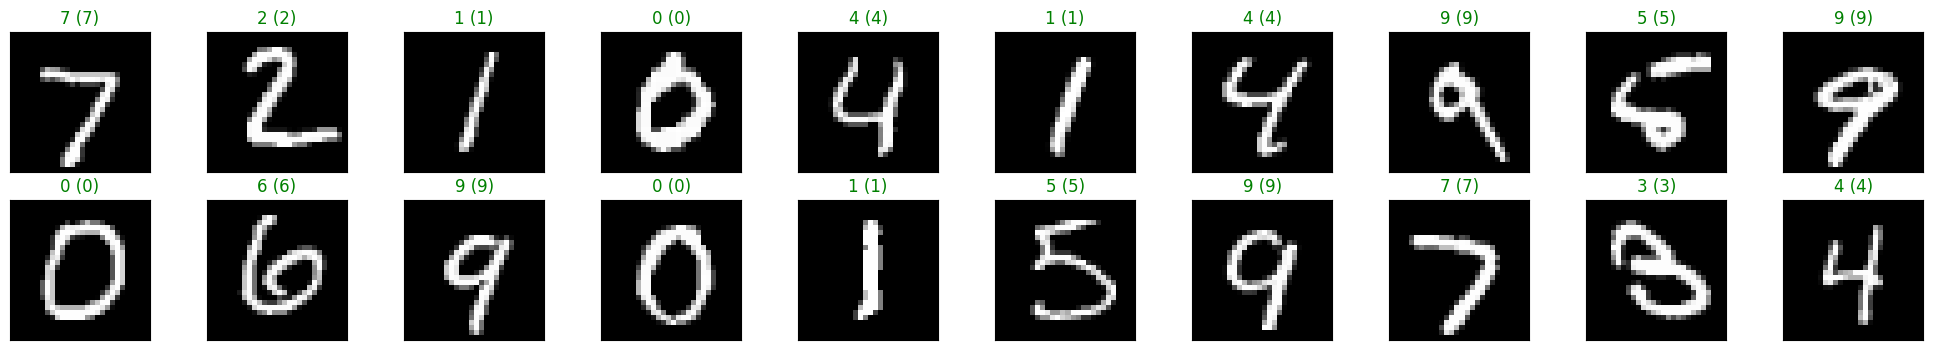

In [31]:
# Testing on set of valiadation images
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output,1)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[],yticks=[])
  plt.imshow(im_convert(images[idx].cpu()), cmap='gray')
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))